Experiment E1-5:
- binary classification
- dataset train 3500, val 1500
- BATCH_SIZE = 20
- IMAGE_SIZE = 256
- EPOCHS = 20
- criterion = nn.BCEWithLogitsLoss()
- optimizer = SGD
- lr=1.0e-3

model:
- self.base_model(x)
- self.globalavg(x) # (2,2)
- self.flatten(x)
- self.fc(x)

In [1]:
import numpy as np
import os
import sys
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, models
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from PIL import Image

In [2]:
# load common py
sys.path.append('../src')
import config
import common_utils
import data_utils
import train_utils
import plot_utils


In [3]:
# override config for experiment
EXP_CODE = "E1-5"
SAVE_FILENAME = f"stage1-{EXP_CODE}-metrics"

config.EPOCHS = 20
config.LEARNING_RATE = 1e-4

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

common_utils.set_seed(config.SEED)


In [5]:
df = pd.read_csv(config.TRAIN_CSV)

In [6]:
# split data into train, val, test 70/15/15
# for fast training, use only 3500 and 1500 samples for train and val

train_df, val_df, test_df, train_small_df, val_small_df = data_utils.split_data(df, config.SEED, small_train_size=3500, small_val_size=1500)

In [7]:
# create transforms
train_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [8]:
# create datasets
train_small_dataset = data_utils.SteelDataset(df=train_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=train_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                    )
val_small_dataset = data_utils.SteelDataset(df=val_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=test_val_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                   )


In [9]:
train_small_loader = DataLoader(train_small_dataset, batch_size=config.BATCH_SIZE,
                          shuffle=True,
                          num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                          )

val_small_loader = DataLoader(val_small_dataset, batch_size=config.BATCH_SIZE,
                         shuffle=False,
                         num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                         )


In [10]:
# create model
class SteelModel(nn.Module):
    def __init__(self):
        super(SteelModel, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1').features
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        #self.base_model.classifier = nn.Identity()

        self.globalavg = nn.AdaptiveAvgPool2d((2, 2))

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(5120, 1),
        )
               

    def forward(self, x):
        x = self.base_model(x)
        #print(x.shape)
        x = self.globalavg(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x 

In [11]:
model = SteelModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config.LEARNING_RATE)

In [12]:
%%time

arr_train_acc = []
arr_train_loss = []
arr_train_precision = []
arr_train_recall = []
arr_train_f1 = []
arr_train_rocauc = []
arr_train_conf_matrix = []

arr_val_acc = []
arr_val_loss = []
arr_val_precision = []
arr_val_recall = []
arr_val_f1 = []
arr_val_rocauc = []
arr_val_conf_matrix = []

idx = 0
for epoch in range(config.EPOCHS):
    train_loss, train_all_labels, train_all_preds, train_all_probs = train_utils.train_one_epoch(model, train_small_loader, criterion, optimizer, device)
    val_loss, val_all_labels, val_all_preds, val_all_probs = train_utils.validate_one_epoch(model, val_small_loader, criterion, device)

    # train metrics
    train_accuracy = (train_all_preds == train_all_labels).mean()
    train_precision = precision_score(train_all_labels, train_all_preds)
    train_recall = recall_score(train_all_labels, train_all_preds)
    train_f1 = f1_score(train_all_labels, train_all_preds)
    train_rocauc = roc_auc_score(train_all_labels, train_all_probs)
    train_conf_matrix = confusion_matrix(train_all_labels, train_all_preds)
    train_tn, train_fp, train_fn, train_tp = train_conf_matrix.ravel()
    
    arr_train_loss.append(train_loss)
    arr_train_acc.append(train_accuracy)
    arr_train_precision.append(train_precision)
    arr_train_recall.append(train_recall)
    arr_train_f1.append(train_f1)
    arr_train_rocauc.append(train_rocauc)
    arr_train_conf_matrix.append({'tn': train_tn, 'fp': train_fp, 'fn': train_fn, 'tp': train_tp})

    # val metrics
    val_accuracy = (val_all_preds == val_all_labels).mean()
    val_precision = precision_score(val_all_labels, val_all_preds)
    val_recall = recall_score(val_all_labels, val_all_preds)
    val_f1 = f1_score(val_all_labels, val_all_preds)
    val_rocauc = roc_auc_score(val_all_labels, val_all_probs)
    val_conf_matrix = confusion_matrix(val_all_labels, val_all_preds)
    val_tn, val_fp, val_fn, val_tp = val_conf_matrix.ravel()

    arr_val_loss.append(val_loss)
    arr_val_acc.append(val_accuracy)
    arr_val_precision.append(val_precision)
    arr_val_recall.append(val_recall)
    arr_val_f1.append(val_f1)
    arr_val_rocauc.append(val_rocauc)
    arr_val_conf_matrix.append({'tn': val_tn, 'fp': val_fp, 'fn': val_fn, 'tp': val_tp})

    print(idx+1)
    print(f"Epoch {epoch+1}/{config.EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f} | ROC AUC: {train_rocauc:.4f}")
    print(f"  Train Confusion Matrix: TN={train_tn}, FP={train_fp}, FN={train_fn}, TP={train_tp}")
    print(f"  Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_rocauc:.4f}")
    print(f"  Val Confusion Matrix: TN={val_tn}, FP={val_fp}, FN={val_fn}, TP={val_tp}")

    idx += 1
    #break


1
Epoch 1/20
  Train Loss: 0.6820 | Train Acc: 0.5683
  Val Loss  : 0.6579 | Val Acc: 0.6080
  Train Precision: 0.5851 | Recall: 0.7195 | F1: 0.6454 | ROC AUC: 0.5720
  Train Confusion Matrix: TN=614, FP=975, FN=536, TP=1375
  Val Precision: 0.6047 | Recall: 0.8144 | F1: 0.6941 | ROC AUC: 0.6440
  Val Confusion Matrix: TN=245, FP=436, FN=152, TP=667
2
Epoch 2/20
  Train Loss: 0.6358 | Train Acc: 0.6680
  Val Loss  : 0.6182 | Val Acc: 0.6847
  Train Precision: 0.6558 | Recall: 0.8247 | F1: 0.7306 | ROC AUC: 0.7093
  Train Confusion Matrix: TN=762, FP=827, FN=335, TP=1576
  Val Precision: 0.6599 | Recall: 0.8718 | F1: 0.7512 | ROC AUC: 0.7452
  Val Confusion Matrix: TN=313, FP=368, FN=105, TP=714
3
Epoch 3/20
  Train Loss: 0.6033 | Train Acc: 0.7057
  Val Loss  : 0.5947 | Val Acc: 0.7047
  Train Precision: 0.6895 | Recall: 0.8388 | F1: 0.7568 | ROC AUC: 0.7736
  Train Confusion Matrix: TN=867, FP=722, FN=308, TP=1603
  Val Precision: 0.6784 | Recall: 0.8730 | F1: 0.7635 | ROC AUC: 0.7796

In [13]:
df_metrics = train_utils.build_metric_df(
    arr_train_loss, arr_train_acc, arr_train_precision, arr_train_recall, 
    arr_train_f1, arr_train_rocauc, arr_train_conf_matrix,
    arr_val_loss, arr_val_acc, arr_val_precision, arr_val_recall, 
    arr_val_f1, arr_val_rocauc, arr_val_conf_matrix
)


In [14]:
df_metrics

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,train_conf_matrix,val_loss,val_acc,val_precision,...,val_rocauc,val_conf_matrix,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
0,0.681982,0.568286,0.585106,0.719519,0.645388,0.571960,"{'tn': 614, 'fp': 975, 'fn': 536, 'tp': 1375}",0.657936,0.608000,0.604714,...,0.644027,"{'tn': 245, 'fp': 436, 'fn': 152, 'tp': 667}",614,975,536,1375,245,436,152,667
1,0.635818,0.668000,0.655847,0.824699,0.730644,0.709320,"{'tn': 762, 'fp': 827, 'fn': 335, 'tp': 1576}",0.618202,0.684667,0.659889,...,0.745200,"{'tn': 313, 'fp': 368, 'fn': 105, 'tp': 714}",762,827,335,1576,313,368,105,714
2,0.603317,0.705714,0.689462,0.838828,0.756846,0.773575,"{'tn': 867, 'fp': 722, 'fn': 308, 'tp': 1603}",0.594668,0.704667,0.678368,...,0.779562,"{'tn': 342, 'fp': 339, 'fn': 104, 'tp': 715}",867,722,308,1603,342,339,104,715
3,0.578989,0.732571,0.713910,0.851387,0.776611,0.804557,"{'tn': 937, 'fp': 652, 'fn': 284, 'tp': 1627}",0.568497,0.735333,0.711847,...,0.812163,"{'tn': 394, 'fp': 287, 'fn': 110, 'tp': 709}",937,652,284,1627,394,287,110,709
4,0.557140,0.744857,0.729073,0.847724,0.783934,0.825664,"{'tn': 987, 'fp': 602, 'fn': 291, 'tp': 1620}",0.551503,0.749333,0.728115,...,0.826898,"{'tn': 417, 'fp': 264, 'fn': 112, 'tp': 707}",987,602,291,1620,417,264,112,707
5,0.544790,0.753714,0.741149,0.843537,0.789036,0.833337,"{'tn': 1026, 'fp': 563, 'fn': 299, 'tp': 1612}",0.536040,0.748667,0.721000,...,0.841193,"{'tn': 402, 'fp': 279, 'fn': 98, 'tp': 721}",1026,563,299,1612,402,279,98,721
6,0.531116,0.766571,0.747511,0.864469,0.801747,0.845683,"{'tn': 1031, 'fp': 558, 'fn': 259, 'tp': 1652}",0.521406,0.769333,0.757345,...,0.850651,"{'tn': 458, 'fp': 223, 'fn': 123, 'tp': 696}",1031,558,259,1652,458,223,123,696
7,0.516255,0.775429,0.762973,0.854003,0.805926,0.857734,"{'tn': 1082, 'fp': 507, 'fn': 279, 'tp': 1632}",0.515278,0.768000,0.748156,...,0.853406,"{'tn': 442, 'fp': 239, 'fn': 109, 'tp': 710}",1082,507,279,1632,442,239,109,710
8,0.504243,0.780571,0.764951,0.863422,0.811209,0.865123,"{'tn': 1082, 'fp': 507, 'fn': 261, 'tp': 1650}",0.503967,0.772000,0.762955,...,0.859074,"{'tn': 466, 'fp': 215, 'fn': 127, 'tp': 692}",1082,507,261,1650,466,215,127,692
9,0.500191,0.783143,0.771442,0.856620,0.811803,0.863457,"{'tn': 1104, 'fp': 485, 'fn': 274, 'tp': 1637}",0.494914,0.774000,0.751046,...,0.865839,"{'tn': 443, 'fp': 238, 'fn': 101, 'tp': 718}",1104,485,274,1637,443,238,101,718


In [15]:
print('Val Metrics:')
print(df_metrics[config.VAL_METRICS])
print('')
print('Val Confusion Matrix:')
print(df_metrics[config.VAL_CF])

Val Metrics:
    val_loss   val_acc  val_precision  val_recall    val_f1  val_rocauc
0   0.657936  0.608000       0.604714    0.814408  0.694069    0.644027
1   0.618202  0.684667       0.659889    0.871795  0.751184    0.745200
2   0.594668  0.704667       0.678368    0.873016  0.763481    0.779562
3   0.568497  0.735333       0.711847    0.865690  0.781267    0.812163
4   0.551503  0.749333       0.728115    0.863248  0.789944    0.826898
5   0.536040  0.748667       0.721000    0.880342  0.792743    0.841193
6   0.521406  0.769333       0.757345    0.849817  0.800921    0.850651
7   0.515278  0.768000       0.748156    0.866911  0.803167    0.853406
8   0.503967  0.772000       0.762955    0.844933  0.801854    0.859074
9   0.494914  0.774000       0.751046    0.876679  0.809014    0.865839
10  0.486581  0.783333       0.777528    0.844933  0.809830    0.869310
11  0.479175  0.780667       0.777778    0.837607  0.806584    0.872724
12  0.474376  0.786000       0.789535    0.829060  

In [16]:
df_metrics.describe()

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,val_loss,val_acc,val_precision,val_recall,val_f1,val_rocauc,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0000,20.0000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.514331,0.764671,0.754487,0.849110,0.798575,0.839630,0.509089,0.762133,0.751042,0.853541,0.797845,0.845014,1053.7000,535.3000,288.350000,1622.650000,444.150000,236.850000,119.950000,699.050000
std,0.067726,0.059971,0.057120,0.032379,0.045379,0.078377,0.061650,0.048362,0.053628,0.018379,0.031334,0.061205,155.0569,155.0569,61.877021,61.877021,73.444053,73.444053,15.052452,15.052452
min,0.438642,0.568286,0.585106,0.719519,0.645388,0.571960,0.440314,0.608000,0.604714,0.814408,0.694069,0.644027,614.0000,389.0000,246.000000,1375.000000,245.000000,162.000000,98.000000,667.000000
25%,0.463886,0.751500,0.738130,0.850471,0.787760,0.831419,0.462072,0.749167,0.726337,0.842186,0.792043,0.837619,1016.2500,427.5000,260.500000,1625.250000,413.250000,183.250000,108.000000,689.750000
50%,0.495911,0.782000,0.769616,0.857405,0.811506,0.866965,0.490748,0.777333,0.765396,0.851038,0.807700,0.867574,1098.5000,490.5000,272.500000,1638.500000,464.500000,216.500000,122.000000,697.000000
75%,0.547878,0.802786,0.793603,0.863684,0.826127,0.884728,0.539906,0.794167,0.789997,0.868132,0.819931,0.882511,1161.5000,572.7500,285.750000,1650.500000,497.750000,267.750000,129.250000,711.000000
max,0.681982,0.816000,0.808939,0.871272,0.837947,0.896807,0.657936,0.802667,0.808737,0.880342,0.823600,0.892358,1200.0000,975.0000,536.000000,1665.000000,519.000000,436.000000,152.000000,721.000000


In [17]:
print(df_metrics.describe())

       train_loss  train_acc  train_precision  train_recall   train_f1  \
count   20.000000  20.000000        20.000000     20.000000  20.000000   
mean     0.514331   0.764671         0.754487      0.849110   0.798575   
std      0.067726   0.059971         0.057120      0.032379   0.045379   
min      0.438642   0.568286         0.585106      0.719519   0.645388   
25%      0.463886   0.751500         0.738130      0.850471   0.787760   
50%      0.495911   0.782000         0.769616      0.857405   0.811506   
75%      0.547878   0.802786         0.793603      0.863684   0.826127   
max      0.681982   0.816000         0.808939      0.871272   0.837947   

       train_rocauc   val_loss    val_acc  val_precision  val_recall  \
count     20.000000  20.000000  20.000000      20.000000   20.000000   
mean       0.839630   0.509089   0.762133       0.751042    0.853541   
std        0.078377   0.061650   0.048362       0.053628    0.018379   
min        0.571960   0.440314   0.608000    

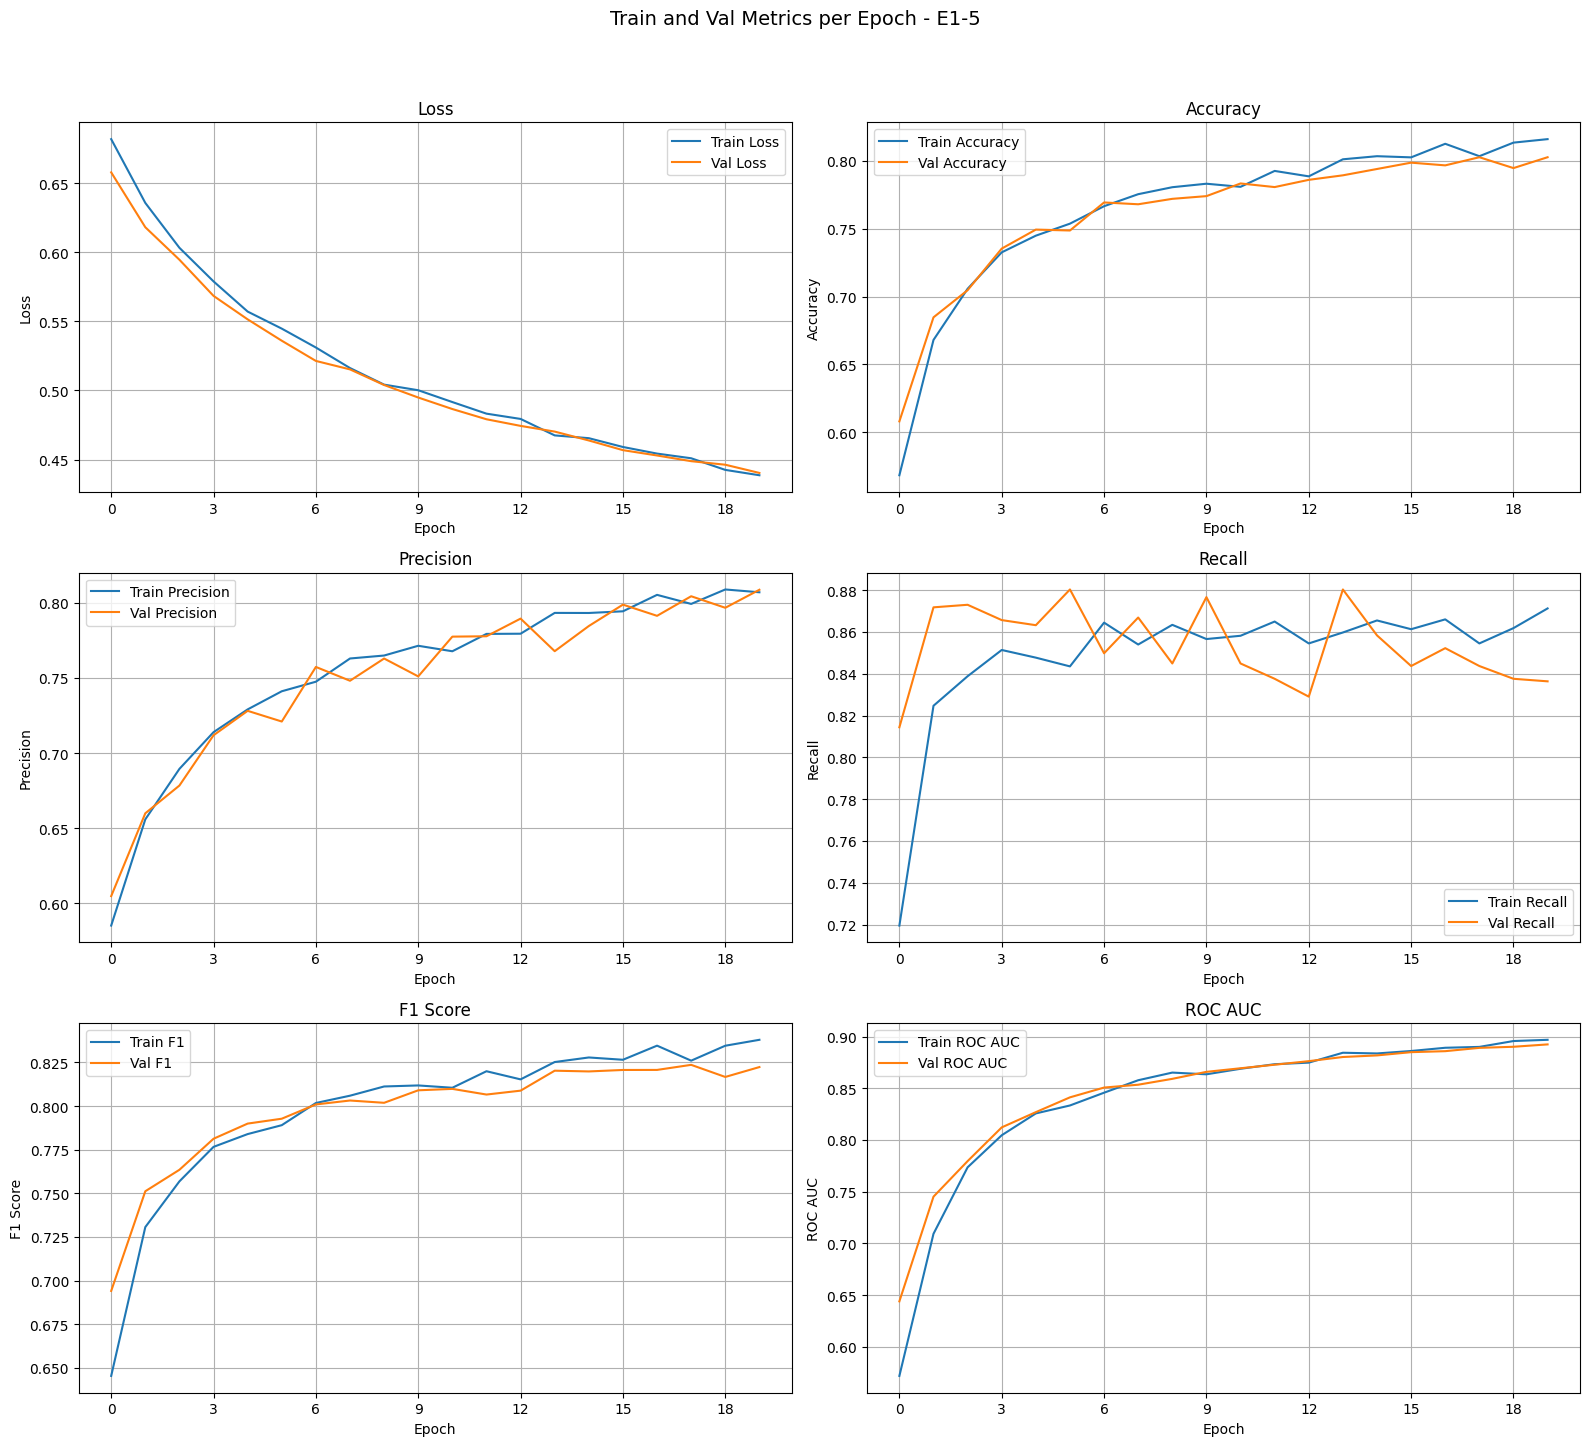

In [18]:
plot_utils.plot_train_val_metrics(df_metrics, exp_code=EXP_CODE, save_path=SAVE_FILENAME+".png")

In [19]:
df_train_conf_matrix = df_metrics['train_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
df_val_conf_matrix = df_metrics['val_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
#df_metrics[['val_tn', 'val_fp', 'val_fn', 'val_tp']]
df_train_conf_matrix.columns = ['train_tn', 'train_fp', 'train_fn', 'train_tp']
df_val_conf_matrix.columns = ['val_tn', 'val_fp', 'val_fn', 'val_tp']



In [20]:
df_train_conf_matrix.describe()

,train_tn,train_fp,train_fn,train_tp
count,20.0000,20.0000,20.000000,20.000000
mean,1053.7000,535.3000,288.350000,1622.650000
std,155.0569,155.0569,61.877021,61.877021
min,614.0000,389.0000,246.000000,1375.000000
25%,1016.2500,427.5000,260.500000,1625.250000
50%,1098.5000,490.5000,272.500000,1638.500000
75%,1161.5000,572.7500,285.750000,1650.500000
max,1200.0000,975.0000,536.000000,1665.000000


In [21]:
df_val_conf_matrix.describe()

,val_tn,val_fp,val_fn,val_tp
count,20.000000,20.000000,20.000000,20.000000
mean,444.150000,236.850000,119.950000,699.050000
std,73.444053,73.444053,15.052452,15.052452
min,245.000000,162.000000,98.000000,667.000000
25%,413.250000,183.250000,108.000000,689.750000
50%,464.500000,216.500000,122.000000,697.000000
75%,497.750000,267.750000,129.250000,711.000000
max,519.000000,436.000000,152.000000,721.000000


In [22]:
df_metrics.to_csv(SAVE_FILENAME+".csv", index=False)